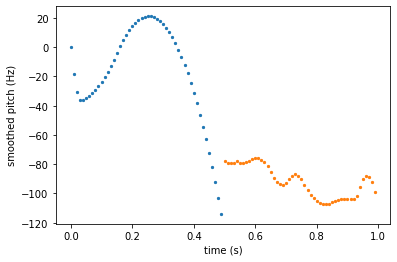

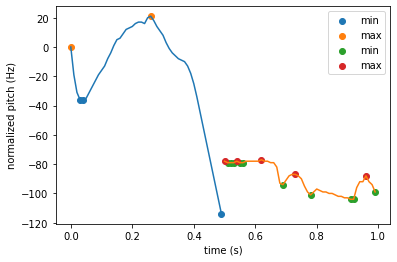

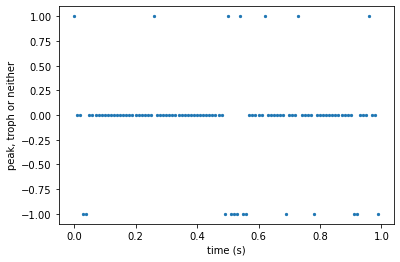

In [279]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d


def read_file2(fileIN):
    data = []
    with open(fileIN,"r") as file:
        for line in file:
            split = line.split()
            sentence = []
            for word in split:
                sentence.append(float(word))
            data.append(sentence)
    file.close()
    return np.array(data)

def determine_peaks(data,precision):
    halfway = int(len(data)/2)
    indexMax = argrelextrema(data[:halfway],np.greater_equal,order=precision)[0]
    indexMin = argrelextrema(data[:halfway],np.less_equal,order=precision)[0]
    indexMax2 = argrelextrema(data[halfway:len(data)],np.greater_equal,order=precision)[0]+halfway
    indexMin2 = argrelextrema(data[halfway:len(data)],np.less_equal,order=precision)[0]+halfway
    return indexMax,indexMin,indexMax2,indexMin2

def test_single_plot(time,data,precision):
    halfway = int(len(data)/2)
    indexMax,indexMin,indexMax2,indexMin2 = determine_peaks(data,precision)
    
    fig,frame = plt.subplots(1,1)
    psize = 2
    # frame.scatter(time,sound,s=psize)
    frame.plot(time[:halfway],data[:halfway])
    frame.plot(time[halfway:len(data)],data[halfway:len(data)])
    
    frame.scatter(time[indexMin],data[indexMin],label="min")
    frame.scatter(time[indexMax],data[indexMax],label="max")
    frame.scatter(time[indexMin2],data[indexMin2],label="min")
    frame.scatter(time[indexMax2],data[indexMax2],label="max")
    
    frame.set_xlabel("time (s)")
    frame.set_ylabel("normalized pitch (Hz)")
    
    frame.legend()
    plt.show()
    
def reduction_trophs(data,precision):
    indexMax,indexMin,indexMax2,indexMin2 = determine_peaks(data,precision)
    reduced = np.zeros(len(data))
    reduced[indexMax] += 1
    reduced[indexMin] -= 1
    reduced[indexMax2] += 1
    reduced[indexMin2] -= 1
    
    fig,frame = plt.subplots(1,1)
    psize = 5
    time = np.arange(len(reduced))/len(reduced)
    frame.scatter(time,reduced,s=psize)
    
    frame.set_xlabel("time (s)")
    frame.set_ylabel("peak, troph or neither")
    plt.show()
    
def smooth_peaks(data,precision):
    halfway = int(len(data)/2)
    indexMax,indexMin,indexMax2,indexMin2 = determine_peaks(data,precision)
    
    indexMax = indexMax.tolist()
    indexMin = indexMin.tolist()
    indexMax2 = indexMax2.tolist()
    indexMin2 = indexMin2.tolist()
    
    peaks = sorted(indexMax + indexMin)
    peaks2 = sorted(indexMin2+indexMax2)
    
    time = np.arange(len(data))/len(data)
    kind = "quadratic"
    cs = interp1d(time[peaks],data[peaks],bounds_error=False,fill_value="extrapolate",kind=kind)
    cs2 = interp1d(time[peaks2],data[peaks2],bounds_error=False,fill_value="extrapolate",kind=kind)
    
    fig =plt.figure()
    frame = fig.add_subplot(1,1,1)
    psize = 5
    frame.scatter(time[:halfway],cs(time[:halfway]),s=psize)
    frame.scatter(time[halfway:len(data)],cs2(time[halfway:len(data)]),s=psize)
    frame.set_xlabel("time (s)")
    frame.set_ylabel("smoothed pitch (Hz)")
    plt.show()
    

    
pitch = read_file2("./data/pitch_data_questions_processed_pitch.txt")
#plot_pitch_data(data)
N = 1
P = 5
time = np.arange(len(pitch[N]))/len(pitch[N])

smooth_peaks(pitch[N],P)
test_single_plot(time,pitch[N],P)
reduction_trophs(pitch[N],P)

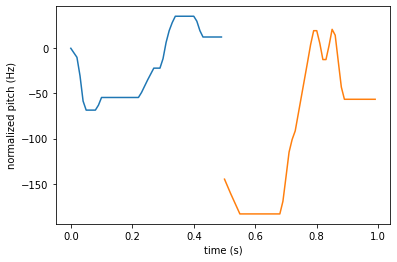

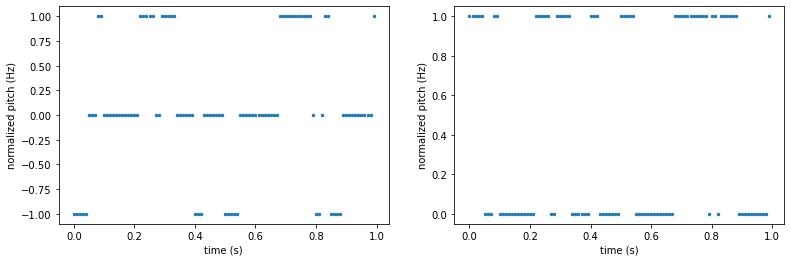

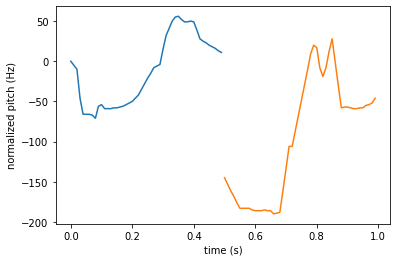

In [101]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d


def read_file2(fileIN):
    data = []
    with open(fileIN,"r") as file:
        for line in file:
            split = line.split()
            sentence = []
            for word in split:
                sentence.append(float(word))
            data.append(sentence)
    file.close()
    return np.array(data)



def test_single_plot(time,data,precision):
    halfway = int(len(data)/2)    
    fig,frame = plt.subplots(1,1)
    psize = 2
    # frame.scatter(time,data,s=psize)
    frame.plot(time[:halfway],data[:halfway])
    frame.plot(time[halfway:len(data)],data[halfway:len(data)])
    
    
    frame.set_xlabel("time (s)")
    frame.set_ylabel("normalized pitch (Hz)")
    
#     frame.legend()
    plt.show()

def determine_smooth_gradient_data(data,time,boundary):
    slope = np.gradient(data,time)
    smooth = [data[0]]
    for idx,dx in enumerate(slope[:len(slope)-1]):
        if np.abs(dx) >= boundary:
            smooth.append(data[idx+1])
        else:
            smooth.append(smooth[idx])
    return smooth

def determine_smooth_gradient_change(data,time,boundary):
    slope = np.gradient(data,time)
    smooth = [data[0]]
    for idx,dx in enumerate(slope[:len(slope)-1]):
        if np.abs(dx) >= boundary:
            smooth.append(smooth[idx]+0.01*dx)
        else:
            smooth.append(smooth[idx])
    return smooth

def find_gradient(data,time,boundary):
    slope = np.gradient(data,time)
    changes = np.zeros(len(data))
    abChange = np.zeros(len(data))
    
    for idx,dx in enumerate(slope):
        if dx >= boundary:
            changes[idx] += 1
            abChange[idx] += 1
        elif dx <= -1*boundary:
            changes[idx] -= 1
            abChange[idx] += 1
    return changes,abChange

def reduction_gradient(data,boundary):
    halfway = int(len(data)/2)
    time = np.arange(len(data))/len(data)
    
    change1,abChange1 = find_gradient(data[:halfway],time[:halfway],boundary)
    change2,abChange2 = find_gradient(data[halfway:len(data)],time[halfway:len(data)],boundary)
        
    fig = plt.figure(figsize=(13,4))
    frame1 = fig.add_subplot(1,2,1)
    frame2 = fig.add_subplot(1,2,2)
    
    psize = 6
    c1 = "#1f77b4" #"#ff7f0e"
    c2 = c1#"#ff7f0e"
    frame1.scatter(time[:halfway],change1,s=psize,c=c1)
    frame1.scatter(time[halfway:len(data)],change2,s=psize,c=c2)
        
    frame1.set_xlabel("time (s)")
    frame1.set_ylabel("normalized pitch (Hz)")
    
    frame2.scatter(time[:halfway],abChange1,s=psize,c=c1)
    frame2.scatter(time[halfway:len(data)],abChange2,s=psize,c=c2)
        
    frame2.set_xlabel("time (s)")
    frame2.set_ylabel("normalized pitch (Hz)")
    
def plot_smooth(data,boundary):
    halfway = int(len(data)/2)
    time = np.arange(len(data))/len(data)
    
    smooth3 = determine_smooth_gradient_change(data[:halfway],time[:halfway],boundary)
    smooth4 = determine_smooth_gradient_change(data[halfway:len(data)],time[halfway:len(data)],boundary)
        
    fig,frame = plt.subplots(1,1)
    psize = 2
    
    frame.plot(time[:halfway],smooth3)
    frame.plot(time[halfway:len(data)],smooth4)
        
    frame.set_xlabel("time (s)")
    frame.set_ylabel("normalized pitch (Hz)")
    
    
pitch = read_file2("./data/pitch_data_questions_processed_pitch.txt")

N = 0
B = 450
time = np.arange(len(pitch[N]))/len(pitch[N])

plot_smooth(pitch[N],B)
reduction_gradient(pitch[N],B)
test_single_plot(time,pitch[N],B)
# reduction_gradient(pitch[N],P)